# Recurrent Neural Network - (شبکه عصبی بازگشتی)
> #### Feed Forward Neural Network
> 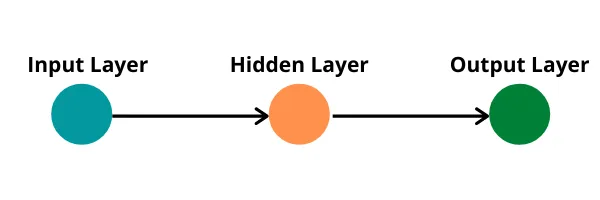 

> #### Feed-Forward Neural Network ---> Recurrent Neural Network
> 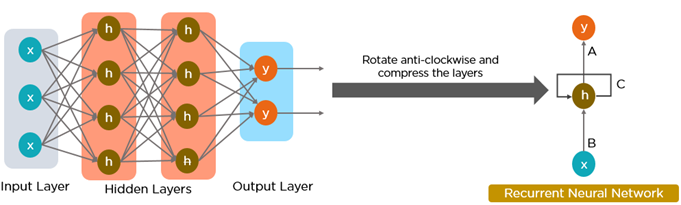 
> #### Recurrent Neural Network - (شبکه عصبی بازگشتی)
> 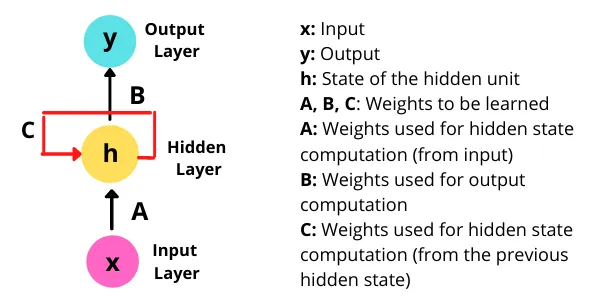
> 
https://karpathy.github.io/2015/05/21/rnn-effectiveness/ 

### Practical : how a chat bot generates "Shiraz is in Iran"

> 1. When processing "is,"   the hidden state retain information about "Shiraz" 
> 2. When processing "in,"   the hidden state retain information about "Shiraz is" 
> 3. When processing "Iran," the hidden state retain information about "Shiraz is in"

> 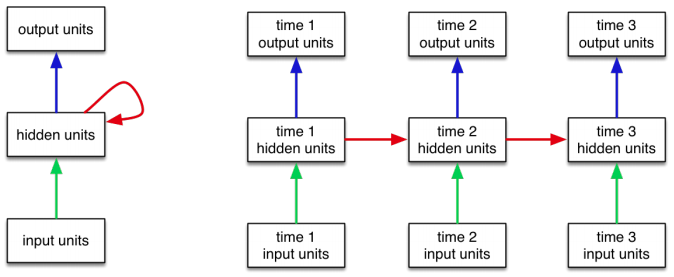 

 
https://karpathy.github.io/2015/05/21/rnn-effectiveness/


##  Recurrent Neural Network (RNN) in Pytorch

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

    torch.nn.RNN(input_size, hidden_size, num_layers=1, nonlinearity='tanh', bias=True, batch_first=False, dropout=0.0, bidirectional=False, device=None, dtype=None)

> ### Parameters
> - input_size – The number of expected features in the input x
> - hidden_size – The number of features in the hidden state h
> - num_layers – Number of recurrent layers. Default: 1
> - nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'
> - bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
> - batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Default: False
> - dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer. Default: 0
> - bidirectional – If True, becomes a bidirectional RNN. Default: False




### How to Determine input_size

- Image Data:
  >the input_size might be the number of pixels or features extracted from each image.

- NLP Applications:
  >input_size is typically the size of the word embeddings.
  
- Time Series:
  >If you have a time series with a single feature, such as temperature readings over time, the input_size would be 1.
  >
  >If you have multiple features at each time step, such as temperature, humidity, and pressure readings, the input_size would be 3.


# Image Classification using RNN

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:

batch_size = 64

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


### Reshape Data

In [5]:
# Get a batch of training data
x_0, label_0 = next(iter(train_loader))
print("x_0 old shape:", x_0.shape)  # Should be (batch_size, 1, 28, 28)

x_0 old shape: torch.Size([64, 1, 28, 28])


In [6]:
# Remove the singleton dimension
x_0 = x_0.squeeze(1)                # New shape is (batch_size, 28, 28)
print("x_0 new shape:", x_0.shape)  # Should be (batch_size, 28, 28)

x_0 new shape: torch.Size([64, 28, 28])


In [7]:
# Define model parameters
input_size = 28   # Each row of the image (28 pixels)
hidden_size = 50  # Number of hidden units
rnn_layer = nn.RNN(input_size, hidden_size, batch_first=True)

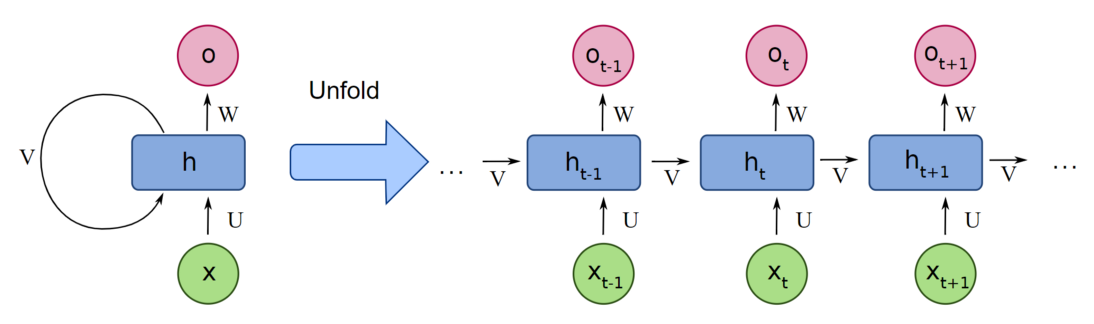

In [12]:
# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        
        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        
        # Define the fully connected layer to map RNN output to the desired output size
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Store the hidden size and number of layers
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, hidden=None):
        # Pass the input through the RNN layer
        out, hidden = self.rnn(x, hidden)
        
        # Take the output from the last time step and pass it through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out
    
    def init_hidden(self, batch_size):
        # Initialize the hidden state with zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

In [13]:
# Hyperparameters
input_size = 28  # Each row of the image
hidden_size = 128
output_size = 10  # Number of classes (digits 0-9)
num_layers = 2
num_epochs = 10
learning_rate = 0.001

# Instantiate the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss for this epoch
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device
        images = images.squeeze(1)  # Remove channel dimension if necessary
        
        optimizer.zero_grad()  # Zero the gradients for the optimizer
        
        # Initialize hidden state
        hidden = model.init_hidden(images.size(0))
        
        # Forward pass
        outputs = model(images, hidden)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Accumulate running loss
        running_loss += loss.item()
    
    # Print average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 0.6836
Epoch [2/10], Loss: 0.2738
Epoch [3/10], Loss: 0.1958
Epoch [4/10], Loss: 0.1723
Epoch [5/10], Loss: 0.1417
Epoch [6/10], Loss: 0.1407
Epoch [7/10], Loss: 0.1274
Epoch [8/10], Loss: 0.1264
Epoch [9/10], Loss: 0.1175
Epoch [10/10], Loss: 0.1149


In [18]:
# Evaluation on test data
model.eval()  # Set the model to evaluation mode
correct = 0  # Initialize count of correct predictions
total = 0  # Initialize total number of predictions

# Disable gradient calculation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.squeeze(1)  # Remove channel dimension if necessary
        
        # Get model predictions
        outputs = model(images)
        
        # Get the predicted class with the highest probability
        _, predicted = torch.max(outputs.data, 1)
        
        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print the test accuracy
print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 97.33%


In [19]:
torch.save(model, 'rnn_image_classification_model.pth')

### RNN vs LSTM vs GRU
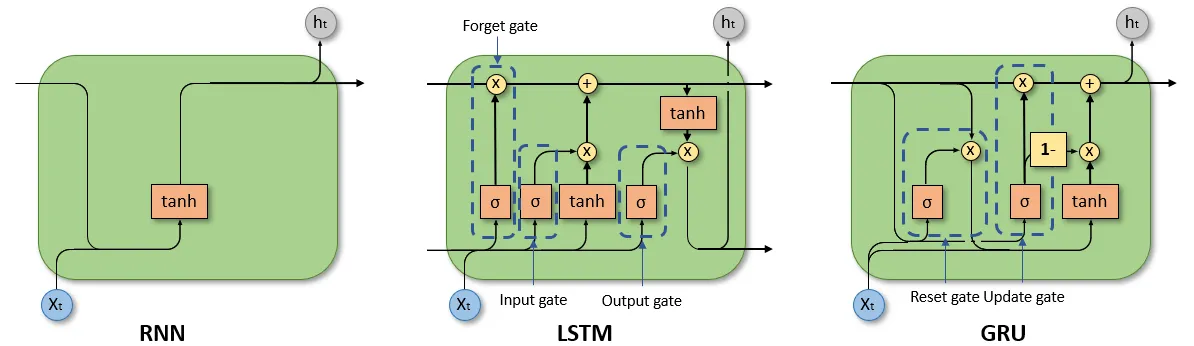
    LSTM and GRU are variants of RNNs that include additional structures to better capture long-term dependencies.